<span style="font-size:250%">Analysing the user data</span>

This notebook is a small side project that aim of getting a better understanding of the available intermediate data set (the experiment groups). It analyzes how secondary language starts are distributed across time and in relation to the java lifecycle of developers.

In [14]:
%load_ext autoreload
%aimport dbUtils
%aimport repoLibrarian
%autoreload 2
import matplotlib.pyplot as pyplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# At which point in their 'career' did developers start to learn their languages?

Initial approaches of evaluation tried to look at a time change dimension of user code quality. I wanted to find out how user programming starts are distributed 

## Absolute

In [27]:
polyglots = dbUtils.runQuery('''
    SELECT * FROM crm20.lb_polyglots
    ORDER BY (SELECT SUM(s) FROM UNNEST(sec_loc) s) DESC
''', True)
display(polyglots)

Time used: 0.08671236038208008


,author_id,java_loc,java_start,java_end,secondary_languages,sec_loc,sec_start,sec_end
0,518570,610901.0,2012-09-14 20:15:46,2019-05-29 13:04:57,[js],[374850],[2015-06-19 19:51:59],[2018-10-06 06:02:11]
1,1482481,797088.0,2014-02-24 19:49:00,2017-10-09 21:49:19,[js],[284106],[2014-05-09 21:48:51],[2017-10-09 21:49:19]
2,3435994,279855.0,2016-06-17 11:21:53,2019-05-22 15:49:21,[js],[221171],[2016-11-15 13:40:40],[2019-05-08 09:53:56]
3,71304,210258.0,2008-12-27 23:11:25,2017-02-14 23:38:23,"[js, py]","[162301, 2270]","[2009-11-20 02:27:15, 2010-03-16 13:49:14]","[2014-09-09 14:07:57, 2010-04-19 18:13:12]"
4,664441,254539.0,2009-04-13 20:55:37,2013-03-11 08:23:39,[js],[161424],[2009-04-13 21:21:32],[2014-05-15 00:20:02]
...,...,...,...,...,...,...,...,...
1540,2410458,6149.0,2014-07-06 15:06:12,2015-03-28 20:06:53,[js],[1004],[2018-10-19 10:59:21],[2018-12-09 14:03:53]
1541,7639819,18859.0,2015-10-03 18:59:18,2018-01-10 00:20:38,[py],[1004],[2017-09-18 19:28:09],[2017-12-21 10:20:55]
1542,86479,389352.0,2011-11-07 20:30:21,2018-01-05 14:33:43,[js],[1003],[2012-02-29 15:06:49],[2018-03-08 22:54:17]
1543,3751266,6009.0,2014-05-19 16:11:19,2016-10-20 13:53:22,[js],[1002],[2014-06-02 07:07:39],[2016-05-25 21:23:05]


This plots user language start times over their rank in secondary: A dot represents a user starting to write s specific language: Blue dots are java starts, green dots are python starts, red dots are javascript starts. The higher up a dot is in the plot, the more secondary language code the ocrresponding author has written (in relation to the others).

The plot shows that there are view polyglots who have started before 2012, and that there is a massive surge in the second half of 2014 - probably some other platform was shut down. It also shows that because of the large spread of beginnings, it is not wise to compare users by absolute time.

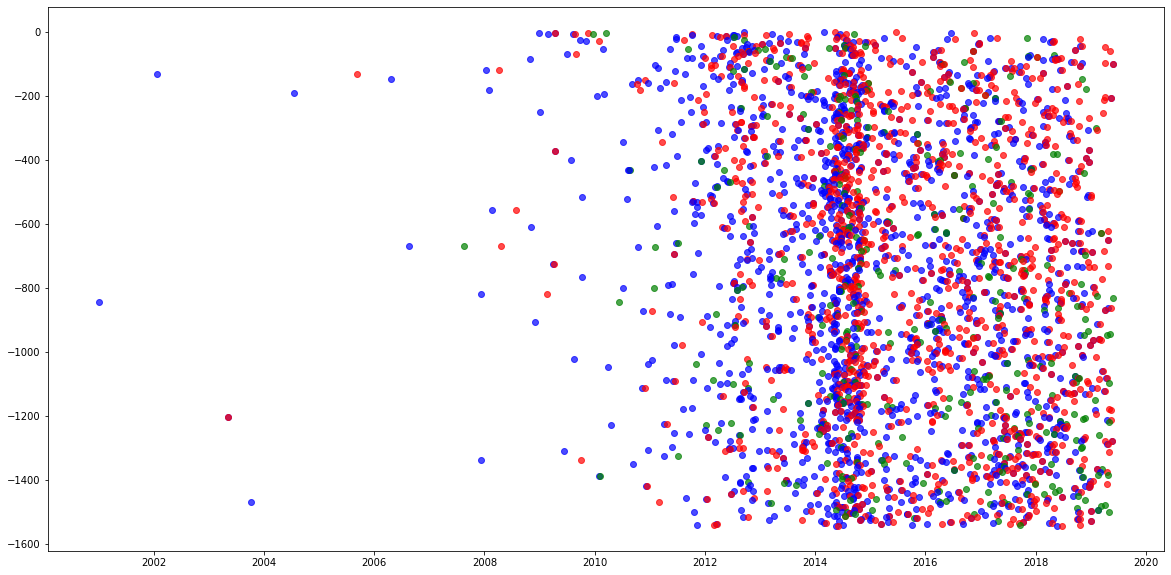

In [28]:
pyplot.figure(figsize=(20, 10))
for index, row in polyglots.iterrows():
    javastart = row['java_start']
    langs = row['secondary_languages']
    starts = row['sec_start']
    pyplot.plot_date([javastart], [-index], 'ob', alpha=0.7)
    for lang, start in zip(langs, starts):
        color = 'r' if lang == 'js' else 'g'
        pyplot.plot_date([start], [-index], 'o'+color, alpha=0.7)

## Relative

Instead, we can analyze relative to the time a developers has been writing Java. Again, this plots developer ranks over their secondary language starts. The result implies that many polyglots start writing their secondary languages very early in their lifecycle.

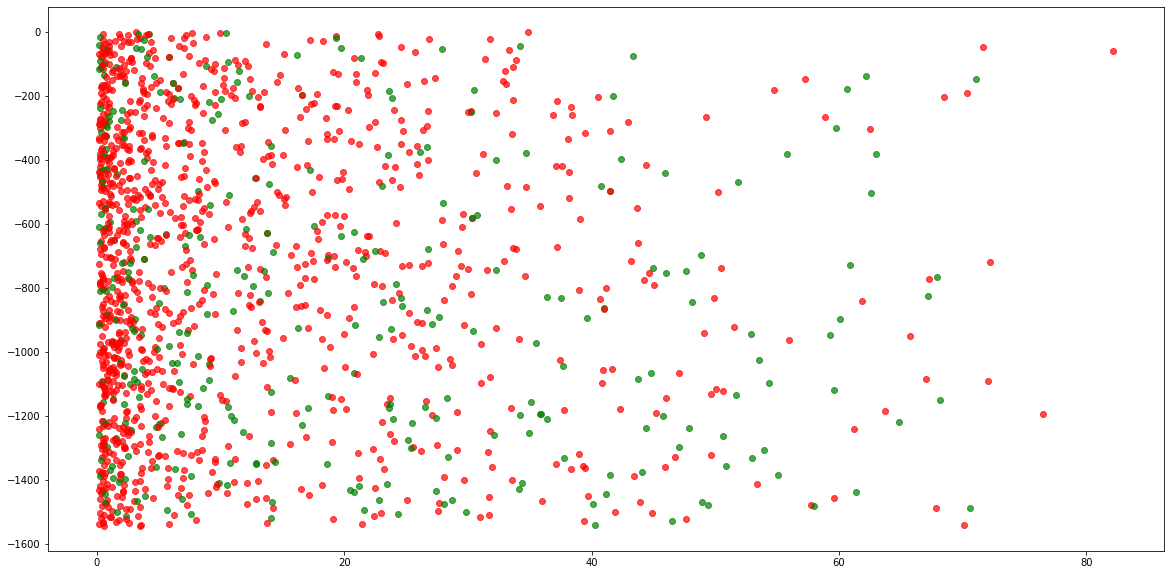

In [32]:
import time
import pandas
pyplot.figure(figsize=(20, 10))

numGroups = 10
groups = {'js' : [0] * numGroups, 'py': [0] * numGroups}

for index, row in polyglots.iterrows():
    javastart = row['java_start']
    langs = row['secondary_languages']
    starts = row['sec_start']
    period = pandas.Timestamp.today()-javastart
    #pyplot.plot_date([javastart, javastart], [0, index], '-b')
    for lang, start in zip(langs, starts):
        color = 'r' if lang == 'js' else 'g'
        delta = (start-javastart)
        if(delta > pandas.Timedelta(days=3)):
            percent = delta/period*100
            groups[lang][int(percent/numGroups)] = groups[lang][int(percent/numGroups)]+1
            pyplot.plot([percent], [-index], 'o'+color, alpha=0.7)
            

Let's formalize this more with a histogram chart: Js starts are in blue, python starts in orange. Language starts are aggregated for each 10% of lifecycle.

The resulting plot shows that indeed, most developers start their secondary language in the very early stages of their java career.

<BarContainer object of 10 artists>

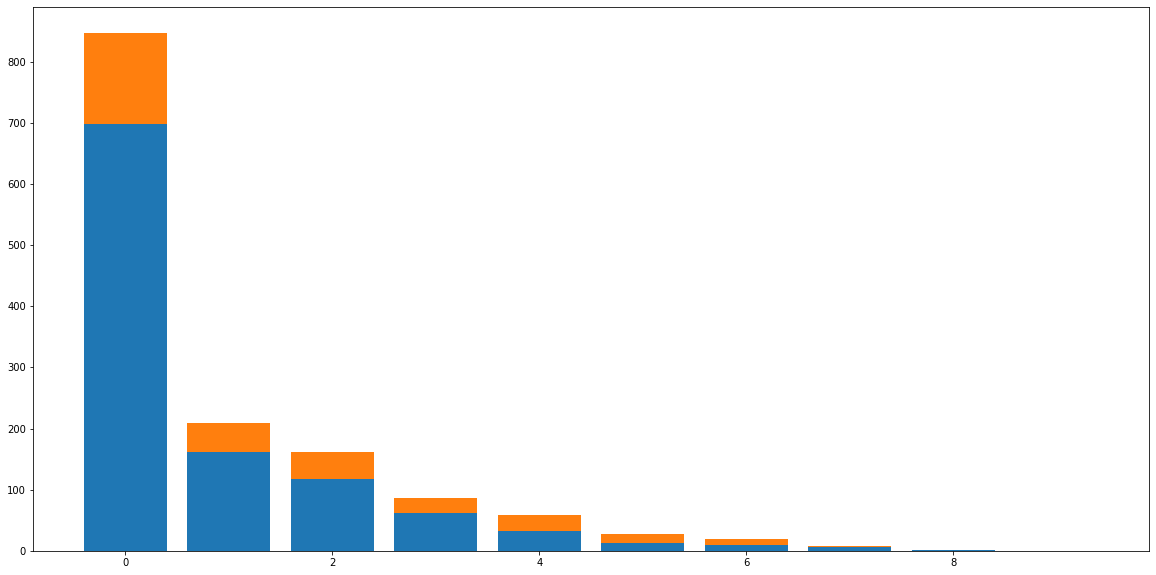

In [31]:
pyplot.figure(figsize=(20, 10))
pyplot.bar(range(numGroups), groups['js'])
pyplot.bar(range(numGroups), groups['py'], bottom = groups['js'])

### Further insights with the java_end column

In the second analysis run, the lifecycle approach was dropped. While, the third analysis run also does not evaluate the run, a `java_end` column was introduced to easy further analyses on the base of developer lifecycle. Now we can also improve our diagrams by actually taking the last java commit of an author into account. Let's see if the results change. We expect authors to start a little bit later in their lifecycle and maybe even some author starting their secondary language after they stopped writing java.

The plot does not give the insights hoped for, because the values of developers that started their secondary language after java end are too extreme. Let's first filter them out to have comparable to to the one above.

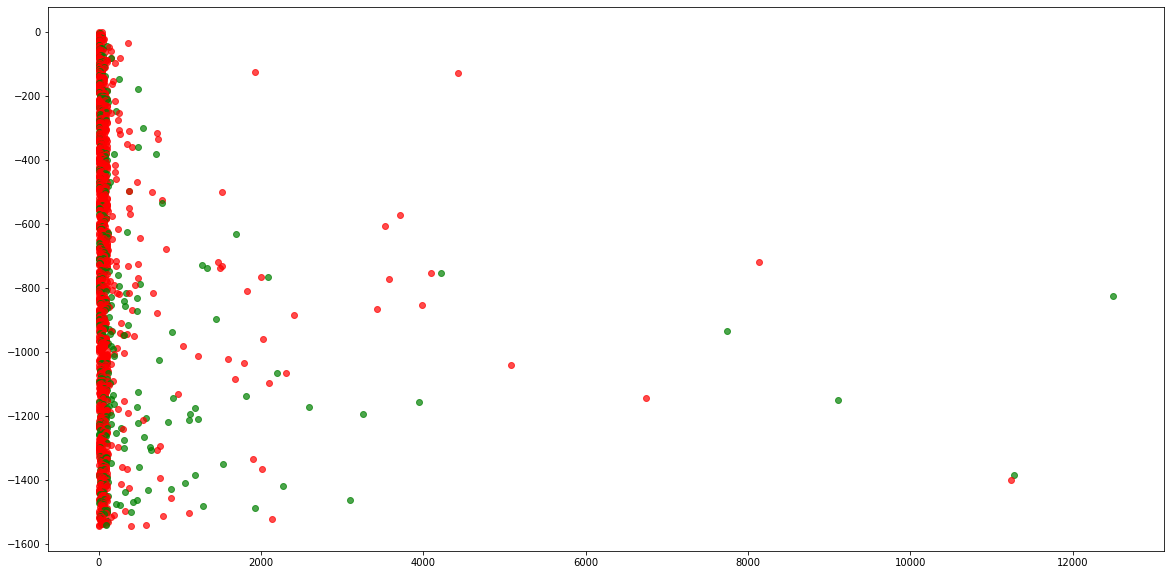

In [36]:
pyplot.figure(figsize=(20, 10))

for index, row in polyglots.iterrows():
    javastart = row['java_start']
    javaend = row['java_end']
    langs = row['secondary_languages']
    starts = row['sec_start']
    period = javaend-javastart
    #pyplot.plot_date([javastart, javastart], [0, index], '-b')
    for lang, start in zip(langs, starts):
        color = 'r' if lang == 'js' else 'g'
        delta = (start-javastart)
        if(delta > pandas.Timedelta(days=3) and period > pandas.Timedelta(days=3)):
            percent = delta/period*100
            pyplot.plot([percent], [-index], 'o'+color, alpha=0.7)
            

Filtering the extreme values out gives an astonishing result: the developers seem to be distributed more evenly!

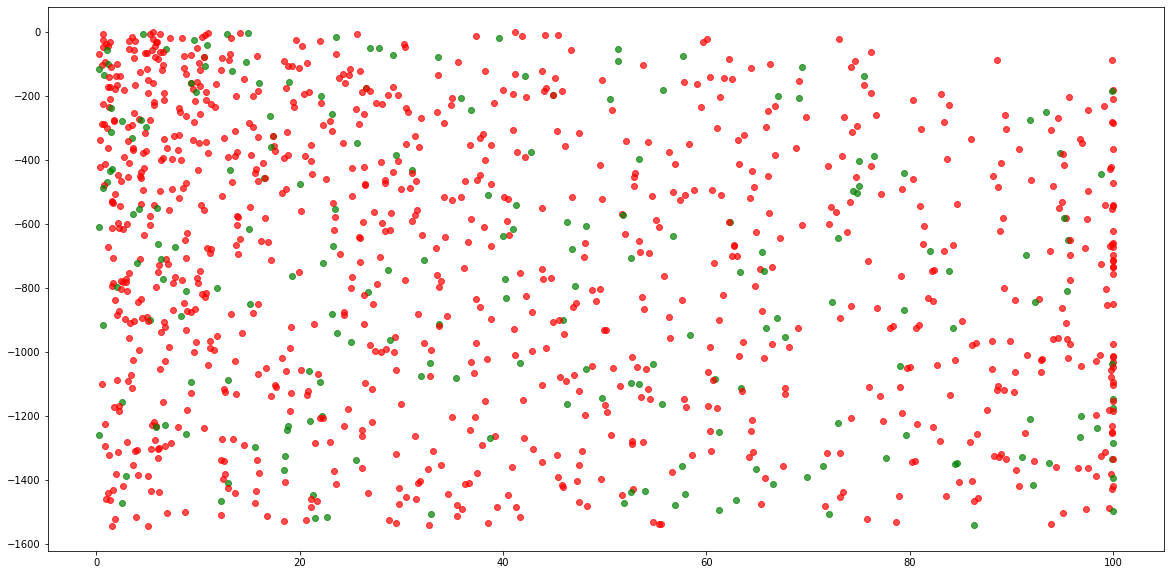

In [43]:
pyplot.figure(figsize=(20, 10))


numGroups = 10
groups = {'js' : [0] * (numGroups), 'py': [0] * (numGroups)}

for index, row in polyglots.iterrows():
    javastart = row['java_start']
    javaend = row['java_end']
    langs = row['secondary_languages']
    starts = row['sec_start']
    period = javaend-javastart
    #pyplot.plot_date([javastart, javastart], [0, index], '-b')
    for lang, start in zip(langs, starts):
        color = 'r' if lang == 'js' else 'g'
        delta = (start-javastart)
        if(delta > pandas.Timedelta(days=3) and period > pandas.Timedelta(days=3)):
            percent = delta/period*100
            if(percent <= 100):
                groupNumber = int(percent*0.99/numGroups)
                groups[lang][groupNumber] = groups[lang][groupNumber]+1
                pyplot.plot([percent], [-index], 'o'+color, alpha=0.7)
            

Let's again make a histogram:

The result shows us that there are still many more who start their secondary language very early. These might be people that actually wrote both languages before and just switched to github. However, now there are also a lot more developers that start their secondary language over the cours of their java lifecycle. There are also a lot who actually start their languages way later.

<BarContainer object of 10 artists>

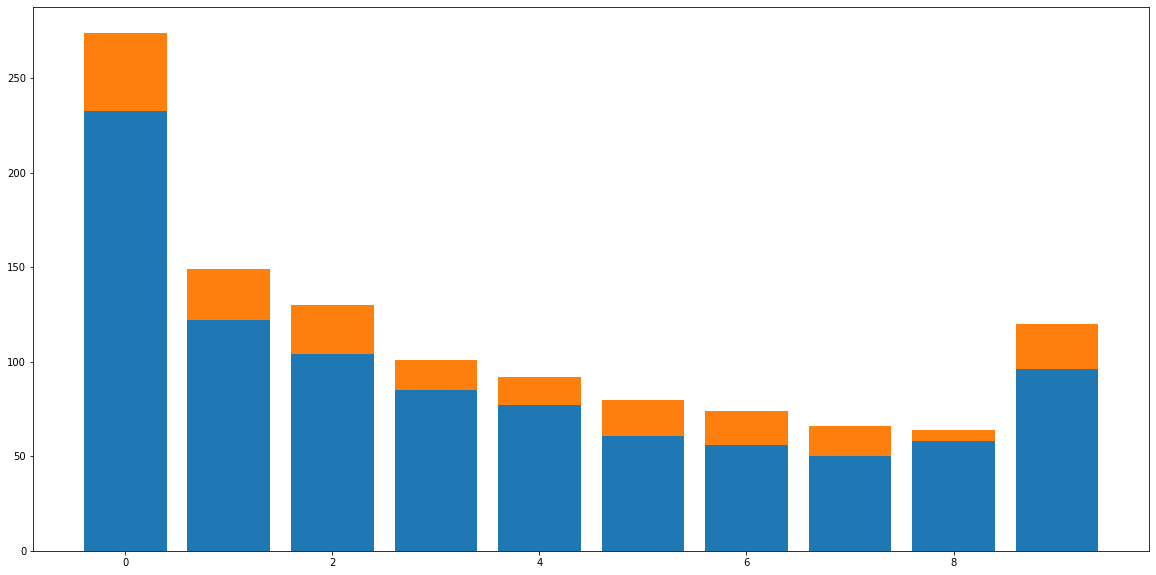

In [44]:
pyplot.figure(figsize=(20, 10))
pyplot.bar(range(numGroups), groups['js'])
pyplot.bar(range(numGroups), groups['py'], bottom = groups['js'])

How many developers still start their seconaries in their java lifecycle? 

In [50]:
print('Js: '+str(sum(groups['js'])))
print('Py: '+str(sum(groups['py'])))

Js: 942
Py: 208


With 1282 js developers and 340 python developers (numbers taken from data explorer), this means there are a lot developers that actually started their secondary language after ending java. This has interesting implications on the analyses run in iterations one to three: As for these developers, learning the secondary language can never have influenced their java style (except maybe for stopping to write it), we actually analyze developers with the mindset of learning a new language. This is an important confounding factor that can be taken into account for future runs.